In [447]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pyLDAvis
import pyLDAvis.gensim  # don't skip this

# Тематическое моделирование обращений жителей к главе г. Троицк (Москва) на официальном сайте города

### (выборка включает обращения за последние 3 года по 13.06.2020, взято по ссылке:
### http://appeal.admtroitsk.ru/viewforum.php?f=9 )

In [1035]:
import pickle

In [851]:
myDf=pd.read_csv("Dudochkin_queries.csv", index_col=False)

In [852]:
myDf.drop("Unnamed: 0",axis=1,inplace=True)

In [ ]:
myDf.views=myDf.views.fillna(0)
myDf.views=myDf.views.astype('int32')

In [1039]:
myDf.head(20)

link                 date  \
0   http://appeal.admtroitsk.ru/viewtopic.php?f=9&...  2020-06-13 13:39:00   
1   http://appeal.admtroitsk.ru/viewtopic.php?f=9&...  2020-06-13 00:23:00   
2   http://appeal.admtroitsk.ru/viewtopic.php?f=9&...  2020-12-06 20:03:00   
3   http://appeal.admtroitsk.ru/viewtopic.php?f=9&...  2020-12-06 15:21:00   
4   http://appeal.admtroitsk.ru/viewtopic.php?f=9&...  2020-11-06 01:10:00   
5   http://appeal.admtroitsk.ru/viewtopic.php?f=9&...  2020-11-06 19:50:00   
6   http://appeal.admtroitsk.ru/viewtopic.php?f=9&...  2020-11-06 09:00:00   
7   http://appeal.admtroitsk.ru/viewtopic.php?f=9&...  2020-09-06 14:14:00   
8   http://appeal.admtroitsk.ru/viewtopic.php?f=9&...  2020-02-06 23:34:00   
9   http://appeal.admtroitsk.ru/viewtopic.php?f=9&...  2020-05-06 00:23:00   
10  http://appeal.admtroitsk.ru/viewtopic.php?f=9&...  2020-03-06 19:46:00   
11  http://appeal.admtroitsk.ru/viewtopic.php?f=9&...  2020-05-28 16:48:00   
12  http://appeal.admtroitsk.ru/viewtopic.php?f=9&...  2020-03-06 15:08:00   
13  http://appeal.admtroitsk.ru/viewtopic.php?f=9&...  2018-12-10 13:40:00   
14  http://appeal.admtroitsk.ru/viewtopic.php?f=9&...  2020-05-20 19:39:00   
15  http://appeal.admtroitsk.ru/viewtopic.php?f=9&...  2020-05-20 15:47:00   
16  http://appeal.admtroitsk.ru/viewtopic.php?f=9&...  2020-05-14 13:25:00   
17  http://appeal.admtroitsk.ru/viewtopic.php?f=9&...  2020-05-18 10:06:00   
18  http://appeal.admtroitsk.ru/viewtopic.php?f=9&...  2020-05-19 22:39:00   
19  http://appeal.admtroitsk.ru/viewtopic.php?f=9&...  2020-05-18 14:09:00   

    views               author  \
0       0          Lappusyonok   
1       0            Anton1983   
2       0               iv1970   
3       0               abryss   
4     205                  Ann   
5     152    Юрий Митрофанович   
6     176               Zilber   
7     188  dashenka.ivanova.11   
8     366               nataly   
9       0               StepaN   
10    294        Николаев А.Г.   
11    357   latorasppn@mail.ru   
12    211              olezek1   
13   2235               Zilber   
14    705              wolf838   
15    396               Zilber   
16    647             citizen1   
17    418              wolf838   
18    367            Ladyveter   
19    269  страдалец Т-Ривьеры   

                                                title  \
0                      Устраните последствия непогоды   
1         Площадка на ул Солнечной 4/6 Центральная 30   
2   Беседка за Октябрьским, 2Терпение жителей на и...   
3                              Борщевик в Троицке - 2   
4                          затопление подъезда в доме   
5                                    Детские площадки   
6                                 Академический сквер   
7                Отказ в выплате на ребенка до 3х лет   
8                    спортивная площадка на Юбилейной   
9                          Предложение на перспективу   
10                            Залило ул Садовую улицу   
11              Теннисные столы в свере Академический   
12                               Строительство дорог!   
13                                      Ледовая арена   
14                                  Новая поликлиника   
15                                    Не вечный огонь   
16                       Газонный "пир во время чумы"   
17  Не дать появлению коллапса на территории гараж...   
18                                     Масочный режим   
19  Срыв срока сдачи Жк Троицкая Ривьера - Голланд...   

                                                 text  
0   Здравствуйте, на крыше дома по адресу микрорай...  
1   Поймите, как жителей людей, чьи окна выходят в...  
2   Уважаемый Владимир Евгеньевич! С 2017 года тян...  
3   Здравствуйте. Ровно год назад я задавала вопро...  
4   Владимир Евгеньевич, здравствуйте.\nВ доме, по...  
5   Детские площадки в Москве должны быть закрыты ...  
6   Владимир Евгеньевич добрый день!\nКак же здоро...  
7   Владимир Евгеньевич, добрый день, \n18 мая по

### Дата записалась в разном формате, а прочиталась в одинаковом, и в некоторых местах месяц перепутался с днем. Т.к. нам нужен месяц, а записи (за редким исключением) сделаны в хронологическом порядке, придется исправить.
### Создадим колонку месяца

In [ ]:
myDf['corr_date']=pd.to_datetime(myDf.date)#, errors='coerce')

In [938]:
def get_month_data(df):
    df["month"]=0
    df.loc[0,"month"]=df.loc[0,"corr_date"].month
    for i in range(1,len(df)):
        prev=df.loc[i-1,'corr_date']
        date=df.loc[i,'corr_date']
        month=date.month
        prev_month=df.loc[i-1,'month']
        if prev_month-date.month<0 or abs(prev_month-date.month)>1:
            if prev.year==date.year:
                month=date.day
            else:
                if month!=12:
                    month=prev_month
        df.loc[i,"month"]=month

In [939]:
get_month_data(myDf)

In [940]:
myDf.month.value_counts()

8     110
10     97
5      90
4      83
3      72
1      72
9      70
6      69
7      68
12     65
11     63
2      61
19     10
21      8
20      7
18      7
13      7
26      5
17      5
27      5
29      4
14      4
16      4
22      4
23      4
28      3
24      3
15      3
25      2
Name: month, dtype: int64

In [951]:
myDf.loc[myDf["month"]>12,"month"]=myDf.loc[myDf["month"]>12,"corr_date"].apply(lambda x: x.month)

In [952]:
myDf.month.value_counts()

8     117
5     105
10    102
4      94
12     76
6      76
2      75
7      74
9      73
3      73
1      72
11     68
Name: month, dtype: int64

### неидеально, но лучше, чем было...

In [1040]:
myDf.head()

link                 date  \
0  http://appeal.admtroitsk.ru/viewtopic.php?f=9&...  2020-06-13 13:39:00   
1  http://appeal.admtroitsk.ru/viewtopic.php?f=9&...  2020-06-13 00:23:00   
2  http://appeal.admtroitsk.ru/viewtopic.php?f=9&...  2020-12-06 20:03:00   
3  http://appeal.admtroitsk.ru/viewtopic.php?f=9&...  2020-12-06 15:21:00   
4  http://appeal.admtroitsk.ru/viewtopic.php?f=9&...  2020-11-06 01:10:00   

   views       author                                              title  \
0      0  Lappusyonok                     Устраните последствия непогоды   
1      0    Anton1983        Площадка на ул Солнечной 4/6 Центральная 30   
2      0       iv1970  Беседка за Октябрьским, 2Терпение жителей на и...   
3      0       abryss                             Борщевик в Троицке - 2   
4    205          Ann                         затопление подъезда в доме   

                                                text           corr_date  \
0  Здравствуйте, на крыше дома по адресу микрорай... 2020-06-13 13:39:00   
1  Поймите, как жителей людей, чьи окна выходят в... 2020-06-13 00:23:00   
2  Уважаемый Владимир Евгеньевич! С 2017 года тян... 2020-12-06 20:03:00   
3  Здравствуйте. Ровно год назад я задавала вопро... 2020-12-06 15:21:00   
4  Владимир Евгеньевич, здравствуйте.\nВ доме, по... 2020-11-06 01:10:00   

   month  
0      6  
1      6  
2      6  
3      6  
4      6

## Предобработка текста:

In [946]:
def prepare_text(init_text, tokenizer, stop_words, morpher):
    init_text=init_text.lower()
    tokens=tokenizer.tokenize(init_text)
    tokens_clear=[]
    for t in tokens:
        if t in stop_words:
            continue
        tokens_clear.append(t)
    tokens_lemmatized=[]
    for t in tokens_clear:
        p = morph.parse(t)[0]
        p=p.normal_form
        tokens_lemmatized.append(p)
    return tokens_lemmatized

In [7]:
def rem_token(lst,token):
    n=lst.count(token)
    if n>0:
        lst.remove(token)
        rem_token(lst,token)
    else:
        return

In [136]:
import re
#import logging

#import gensim.downloader as api
#import nltk
from gensim.models import CoherenceModel
import gensim.corpora as corpora
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer

import pymorphy2

In [9]:
stop_words = stopwords.words('russian')

In [10]:
tokenizer = RegexpTokenizer('\w+|[^\w\s]+\.') # с паттернами сложно, надо отрегулировать #'\w+|[^\w\s]+'

In [11]:
morph = pymorphy2.MorphAnalyzer()

In [854]:
myDf["Tokens lemmatized"]=myDf.text.apply(lambda x: prepare_text(x, tokenizer, stop_words, morph))

In [1041]:
myDf.head(20)

link                 date  \
0   http://appeal.admtroitsk.ru/viewtopic.php?f=9&...  2020-06-13 13:39:00   
1   http://appeal.admtroitsk.ru/viewtopic.php?f=9&...  2020-06-13 00:23:00   
2   http://appeal.admtroitsk.ru/viewtopic.php?f=9&...  2020-12-06 20:03:00   
3   http://appeal.admtroitsk.ru/viewtopic.php?f=9&...  2020-12-06 15:21:00   
4   http://appeal.admtroitsk.ru/viewtopic.php?f=9&...  2020-11-06 01:10:00   
5   http://appeal.admtroitsk.ru/viewtopic.php?f=9&...  2020-11-06 19:50:00   
6   http://appeal.admtroitsk.ru/viewtopic.php?f=9&...  2020-11-06 09:00:00   
7   http://appeal.admtroitsk.ru/viewtopic.php?f=9&...  2020-09-06 14:14:00   
8   http://appeal.admtroitsk.ru/viewtopic.php?f=9&...  2020-02-06 23:34:00   
9   http://appeal.admtroitsk.ru/viewtopic.php?f=9&...  2020-05-06 00:23:00   
10  http://appeal.admtroitsk.ru/viewtopic.php?f=9&...  2020-03-06 19:46:00   
11  http://appeal.admtroitsk.ru/viewtopic.php?f=9&...  2020-05-28 16:48:00   
12  http://appeal.admtroitsk.ru/viewtopic.php?f=9&...  2020-03-06 15:08:00   
13  http://appeal.admtroitsk.ru/viewtopic.php?f=9&...  2018-12-10 13:40:00   
14  http://appeal.admtroitsk.ru/viewtopic.php?f=9&...  2020-05-20 19:39:00   
15  http://appeal.admtroitsk.ru/viewtopic.php?f=9&...  2020-05-20 15:47:00   
16  http://appeal.admtroitsk.ru/viewtopic.php?f=9&...  2020-05-14 13:25:00   
17  http://appeal.admtroitsk.ru/viewtopic.php?f=9&...  2020-05-18 10:06:00   
18  http://appeal.admtroitsk.ru/viewtopic.php?f=9&...  2020-05-19 22:39:00   
19  http://appeal.admtroitsk.ru/viewtopic.php?f=9&...  2020-05-18 14:09:00   

    views               author  \
0       0          Lappusyonok   
1       0            Anton1983   
2       0               iv1970   
3       0               abryss   
4     205                  Ann   
5     152    Юрий Митрофанович   
6     176               Zilber   
7     188  dashenka.ivanova.11   
8     366               nataly   
9       0               StepaN   
10    294        Николаев А.Г.   
11    357   latorasppn@mail.ru   
12    211              olezek1   
13   2235               Zilber   
14    705              wolf838   
15    396               Zilber   
16    647             citizen1   
17    418              wolf838   
18    367            Ladyveter   
19    269  страдалец Т-Ривьеры   

                                                title  \
0                      Устраните последствия непогоды   
1         Площадка на ул Солнечной 4/6 Центральная 30   
2   Беседка за Октябрьским, 2Терпение жителей на и...   
3                              Борщевик в Троицке - 2   
4                          затопление подъезда в доме   
5                                    Детские площадки   
6                                 Академический сквер   
7                Отказ в выплате на ребенка до 3х лет   
8                    спортивная площадка на Юбилейной   
9                          Предложение на перспективу   
10                            Залило ул Садовую улицу   
11              Теннисные столы в свере Академический   
12                               Строительство дорог!   
13                                      Ледовая арена   
14                                  Новая поликлиника   
15                                    Не вечный огонь   
16                       Газонный "пир во время чумы"   
17  Не дать появлению коллапса на территории гараж...   
18                                     Масочный режим   
19  Срыв срока сдачи Жк Троицкая Ривьера - Голланд...   

                                                 text  \
0   Здравствуйте, на крыше дома по адресу микрорай...   
1   Поймите, как жителей людей, чьи окна выходят в...   
2   Уважаемый Владимир Евгеньевич! С 2017 года тян...   
3   Здравствуйте. Ровно год назад я задавала вопро...   
4   Владимир Евгеньевич, здравствуйте.\nВ доме, по...   
5   Детские площадки в Москве должны быть закрыты ...   
6   Владимир Евгеньевич добрый день!\nКак же здоро...   
7   Владимир Евгеньевич, добрый день, \n1

## Биграммы и словарь

In [1]:
import gensim

In [28]:
docs=myDf["Tokens lemmatized"]

In [531]:
bigram = gensim.models.Phrases(docs, min_count=5, threshold=60) #настроить threshold
bigram_mod = gensim.models.phrases.Phraser(bigram)

In [532]:
data_bigrams=[bigram_mod[w] for w in docs]

In [533]:
len(bigram.vocab)

62289

In [690]:
id2word = corpora.Dictionary(data_bigrams)

In [691]:
len(id2word)

9673

In [692]:
id2word.filter_extremes(no_below=2,no_above=0.05)

In [693]:
len(id2word)

4701

In [694]:
corpus = [id2word.doc2bow(text) for text in data_bigrams]

In [547]:
#n_topics=17

In [548]:
#lda_model = gensim.models.ldamodel.LdaModel(
        #corpus=corpus,
        #id2word=id2word,
        #num_topics=n_topics, 
        #random_state=100,
        #update_every=1,
        #chunksize=100,
        #passes=10,
        #alpha='auto',
        #per_word_topics=True)

In [1042]:
#print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
#coherence_model_lda = CoherenceModel(model=lda_model, texts=data_bigrams, dictionary=id2word, coherence='c_v')
#coherence_lda = coherence_model_lda.get_coherence()
#print('\nCoherence Score: ', coherence_lda)

In [695]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(
            corpus=corpus,
            id2word=dictionary,
            num_topics=num_topics, 
            random_state=100,
            update_every=1,
            chunksize=100,
            passes=10,
            alpha='auto',
            per_word_topics=True)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

### Экспериментально определено, что оптимальное количество тем лежит между 15 и 35

In [696]:
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_bigrams, start=17, limit=31, step=1)

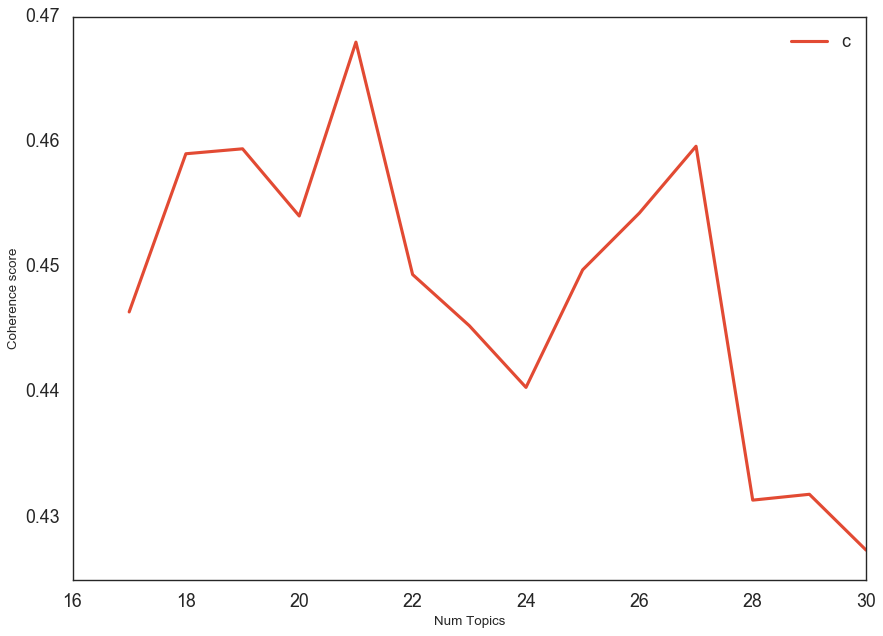

In [697]:
limit=31; start=17; step=1;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [698]:
lda_model=model_list[4] # 21 тема выглядит наиболее удачным выбором
#lda_model=model_list[2]
#lda_model=model_list[3]
#lda_model=model_list[4]

In [1033]:
lda_model.save('lda_default.pkl')
np.save('lda_model_expElogbeta.npy',lda_model.expElogbeta)

In [1036]:
#with open('lda_default.pkl', 'rb') as f:
    #ldamodel_loaded = pickle.load(f)

In [1037]:
#expElogbeta = np.load("lda_model_expElogbeta.npy")
#ldamodel_loaded.expElogbeta = expElogbeta

In [699]:
n_topics=21

In [734]:
topics=lda_model.show_topics(num_topics=n_topics, num_words=100,formatted=False)

In [213]:
from wordcloud import WordCloud  # Пакет для построения облаков слов

In [ ]:
import seaborn as sns

In [453]:
plt.style.available

['bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn-bright', 'seaborn-colorblind', 'seaborn-dark-palette', 'seaborn-dark', 'seaborn-darkgrid', 'seaborn-deep', 'seaborn-muted', 'seaborn-notebook', 'seaborn-paper', 'seaborn-pastel', 'seaborn-poster', 'seaborn-talk', 'seaborn-ticks', 'seaborn-white', 'seaborn-whitegrid', 'seaborn', 'Solarize_Light2', 'tableau-colorblind10', '_classic_test']

In [463]:
#plt.style.use('ggplot')          # задаём красивый стиль для графиков matplotlib-а
plt.style.use('seaborn-white')
#%matplotlib inline

In [1046]:
def plotWordCloud(topic_number, topics):
    """
        Строит визуализацию слов на основе текстов топиков
    """
    # получаем частоты и слова топика
    
    text = dict(topics[topic_number][1])
    
    # строим облако слов
    wordcloud = WordCloud(background_color="white", max_words=50, width=900, height=900, collocations=False)
    wordcloud = wordcloud.generate_from_frequencies(text)
    plt.figure(figsize=(8, 8))
    plt.title("Топик номер {}".format(topic_number))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off");

C:\local\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  if sys.path[0] == '':


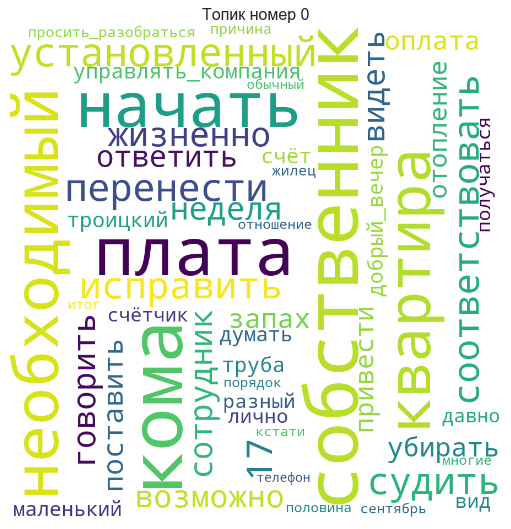

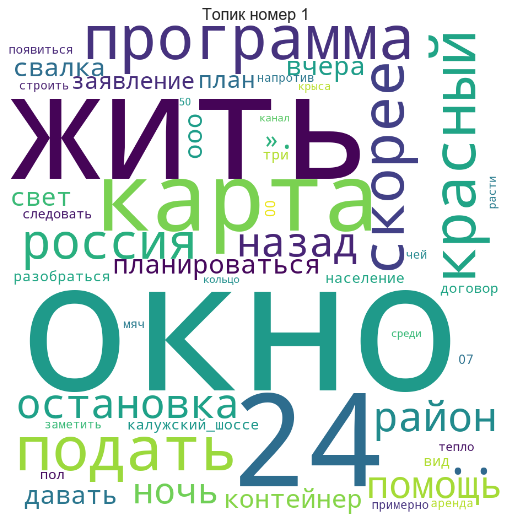

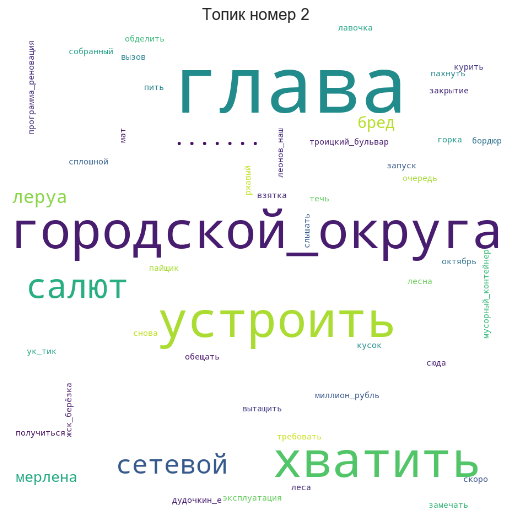

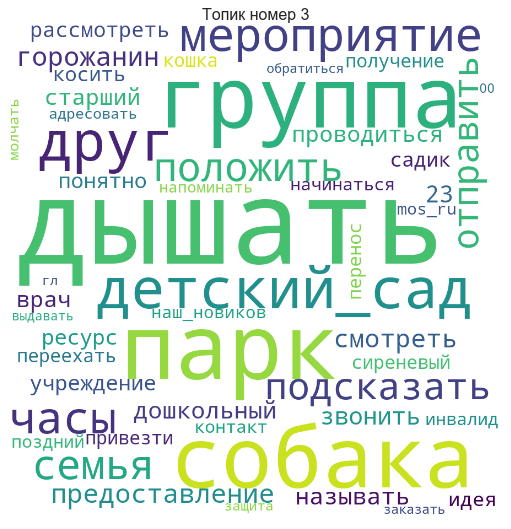

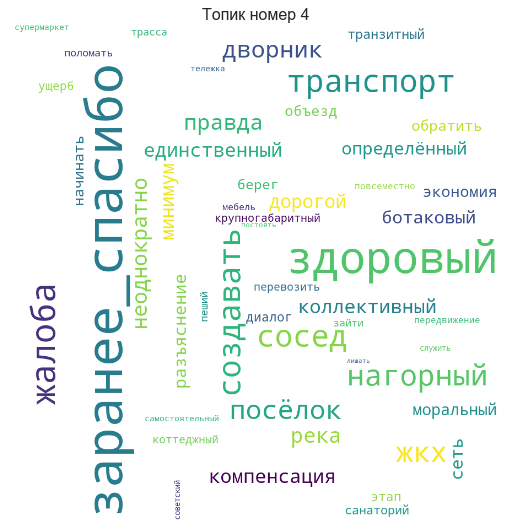

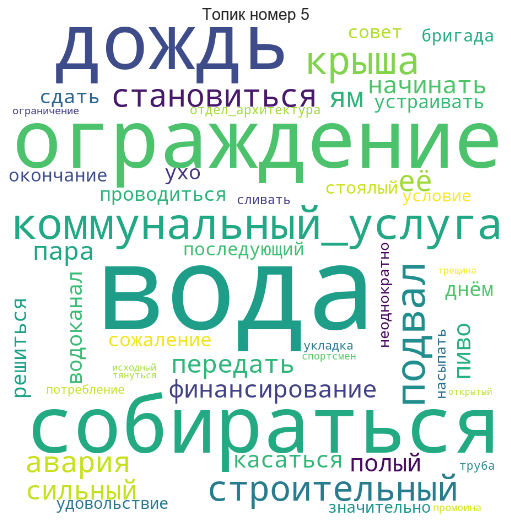

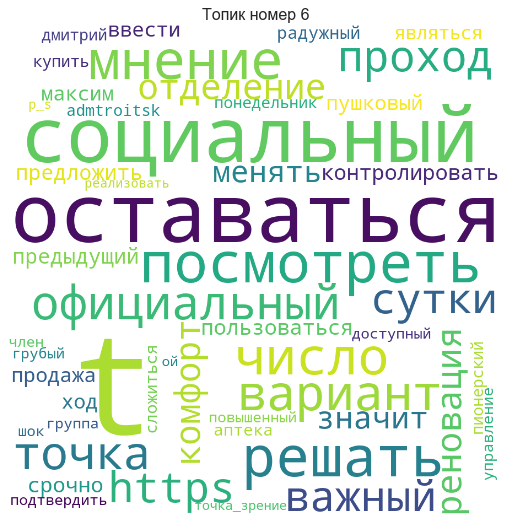

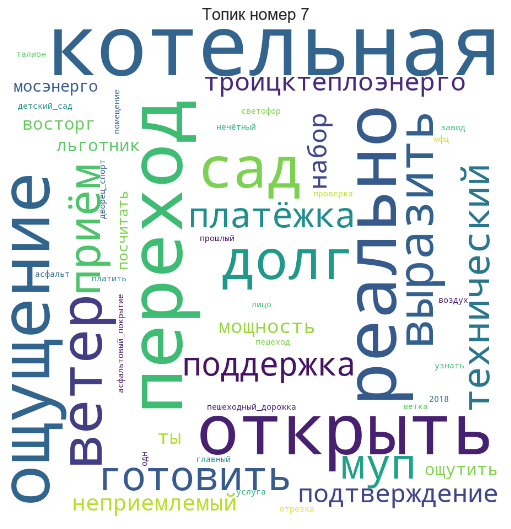

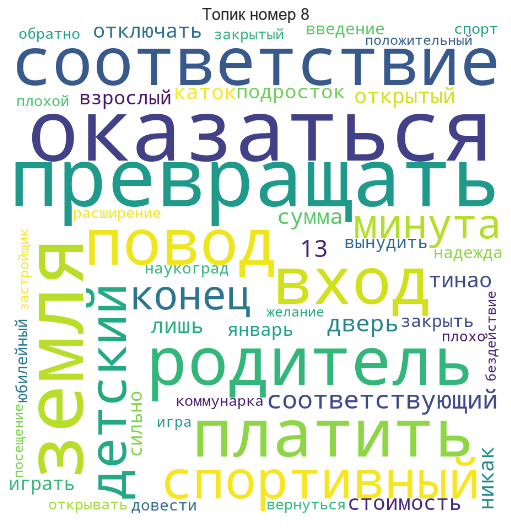

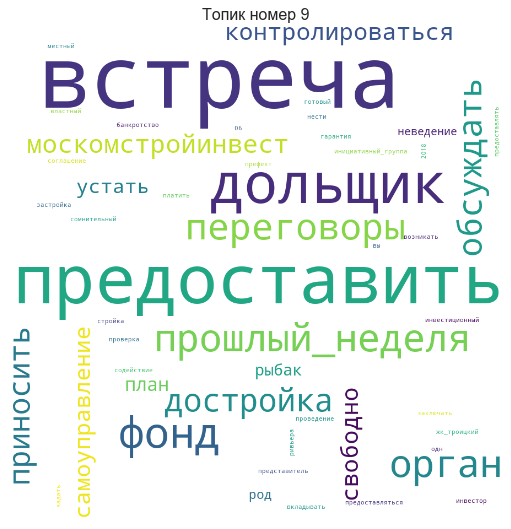

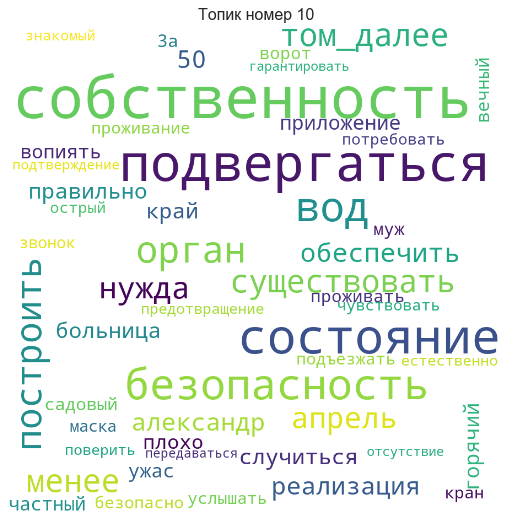

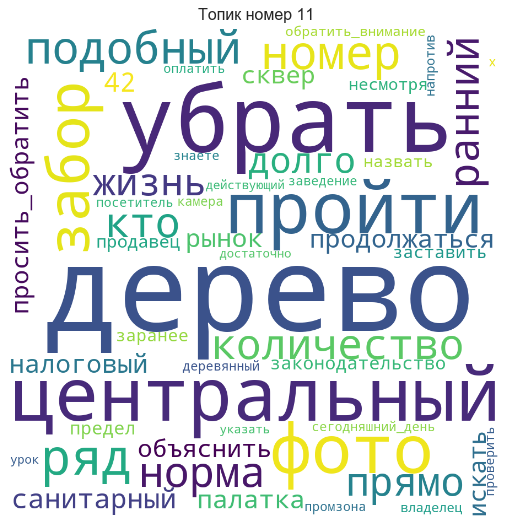

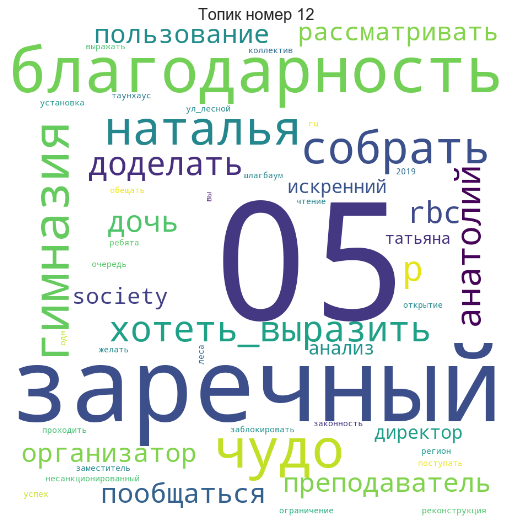

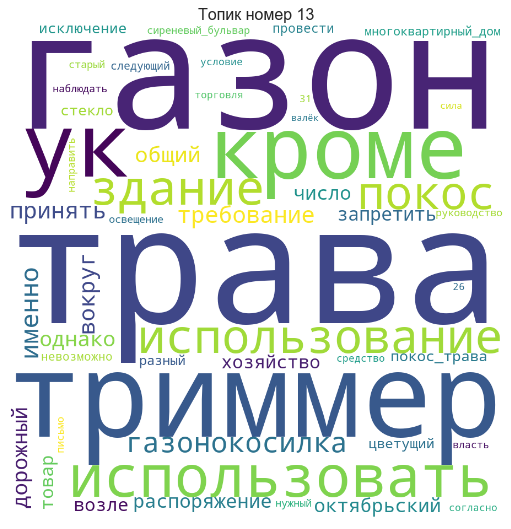

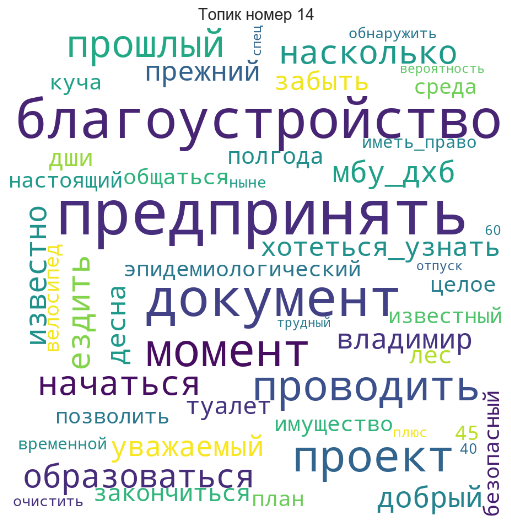

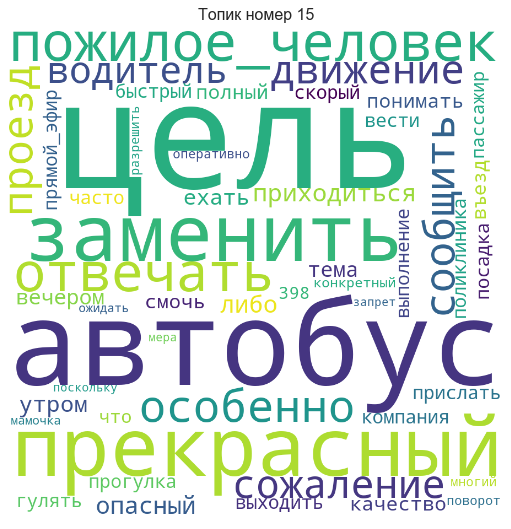

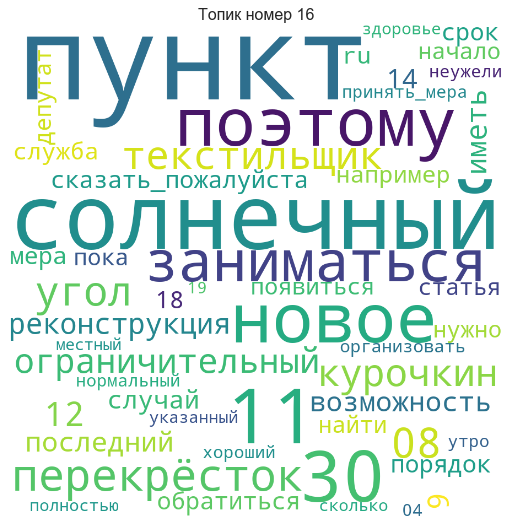

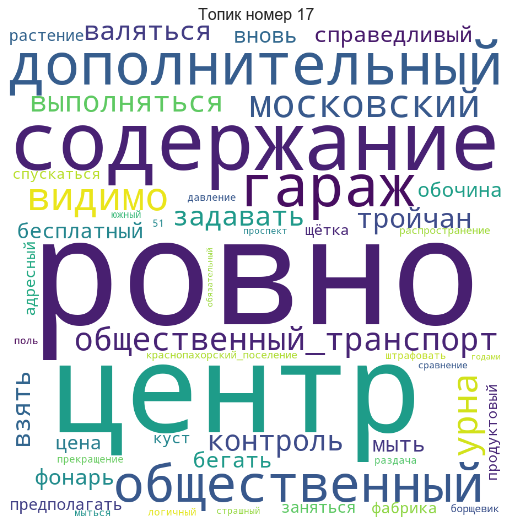

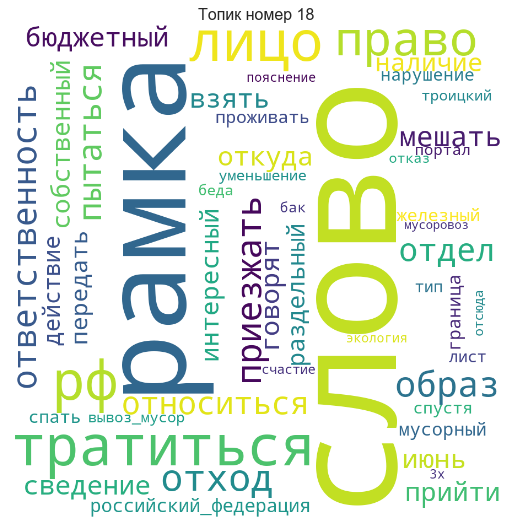

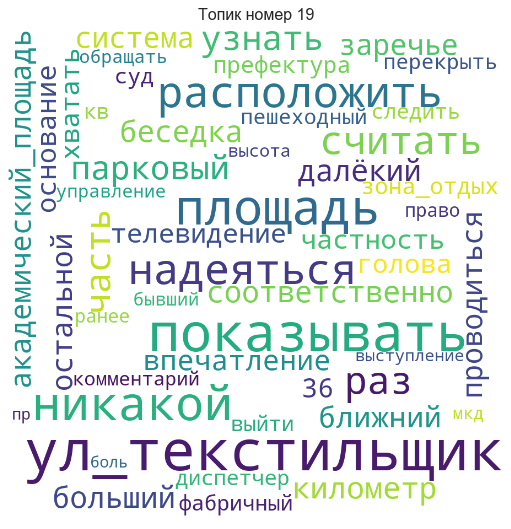

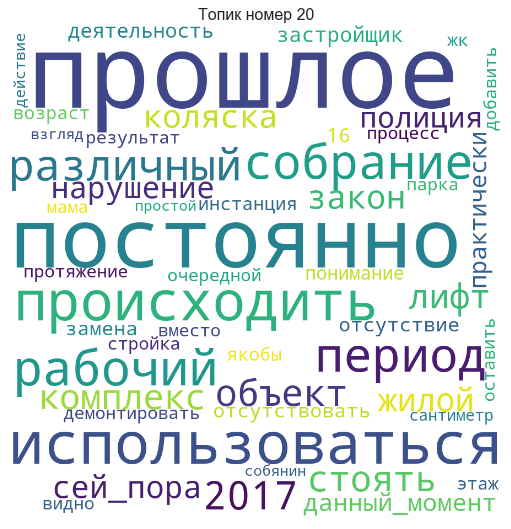

In [1047]:
for i in range(0,n_topics):
    plotWordCloud(i,topics)

## Названия тем, полученные методом пристального взгляда:

In [759]:
topic_titles={0:'-',
              1:'Вывоз мусора и свалки',
              2:'-',
              3:'Семья и дошкольные учреждения',
              4:'Транспорт и ЖКХ для коттеджных поселков на окраинах',
              5:'Аварии на улицах, затопления',
              6:'Проблемы социального обеспечения и комфорта',
              7:'Работа котельный, оплата отопления',
              8:'Спорт и дети',
              9:'Обманутые дольщики, строительство, кооперативы',
              10:'Безопасность в условиях пандемии',
              11:'Проблемы для пешеходов на улицах города',
              12:'Отзывы о школе, преподавателях',
              13:'Покос травы и газоны',
              14:'Работа коммунальных служб и благоустройство',
              15:'Общественный транспорт - комфорт',
              16:'-',
              17:'Общественный транспорт - маршруты, цена, расписание',
              18:'Раздельный сбор отходов и вывоз мусора',
              19:'Благоустройство пешеходных зон и зон отдыха',
              20:'Обслуживание жилых домов, ЖКХ, жалобы жителей'}

# ML

## Попытаемся ответить на вопросы:
## 1) Какие из топиков - самые злободневные (по количеству обращений и просмотров)
## 2) Каково распределение топиков по месяцам?
## 3) Какие топики поднимают наиболее активные пользователи?

In [761]:
def get_topics_proba(model, corpus, n_topics):
    proba=[0]*n_topics
    for i in range(0,len(corpus)):
        text_topics=model.get_document_topics(corpus[i])
        for t in text_topics:
            proba[t[0]]+=t[1]
    proba=[x/len(corpus) for x in proba]
    return proba

In [766]:
def get_topic_df(topic_titles):
    ind=[]
    for i in range(0,len(topic_titles)):
        b=topic_titles[i]
        if len(b)>40:
            b=b[0:34]+'...'
        ind.append(b)
    to_plot=pd.DataFrame(index=ind)
    return to_plot

In [767]:
to_plot=get_topic_df(topic_titles)

In [963]:
def get_topic_views(data, model, corpus, n_topics):
    topic_views=[0]*n_topics
    for i in range(0,len(corpus)):
        text_topics=model.get_document_topics(corpus[i],minimum_probability=0.05)
        text_topics = sorted(text_topics, key=lambda w: w[1], reverse=True)
        if len(text_topics)>3:
            text_topics=text_topics[0:3]
        for t in text_topics:
            topic_views[t[0]]+=data.loc[i,'views']
    return topic_views        

In [810]:
def plot_topic_proba(proba, views, to_plot):
    vm=max(views)
    pm=max(proba)
    views=[x*pm/vm for x in views]
    to_plot["proba"]=proba
    to_plot["views"]=views
    fig, ax=plt.subplots(figsize=(15,10))
    #plt.figure(figsize=(15,15))
    plt.xticks(rotation=60, ha="right",fontsize=18);
    plt.yticks(fontsize=18);
    to_plot["proba"].plot(kind='bar', title="Topic distribution", legend=True, color='red', position=0.1)
    to_plot["views"].plot(kind='bar', legend=True, color='blue', position=0.5)
    plt.show()

In [800]:
proba=get_topics_proba(lda_model, corpus, n_topics) # вероятность/частота появления темы во всех полученных данных, как среднее от вероятности по топикам

In [964]:
views=get_topic_views(myDf, lda_model, corpus, 21)

In [965]:
max(views)

556320

## Распределение наиболее упоминаемых тем (в среднем по текстам, и по количеству просмотров)

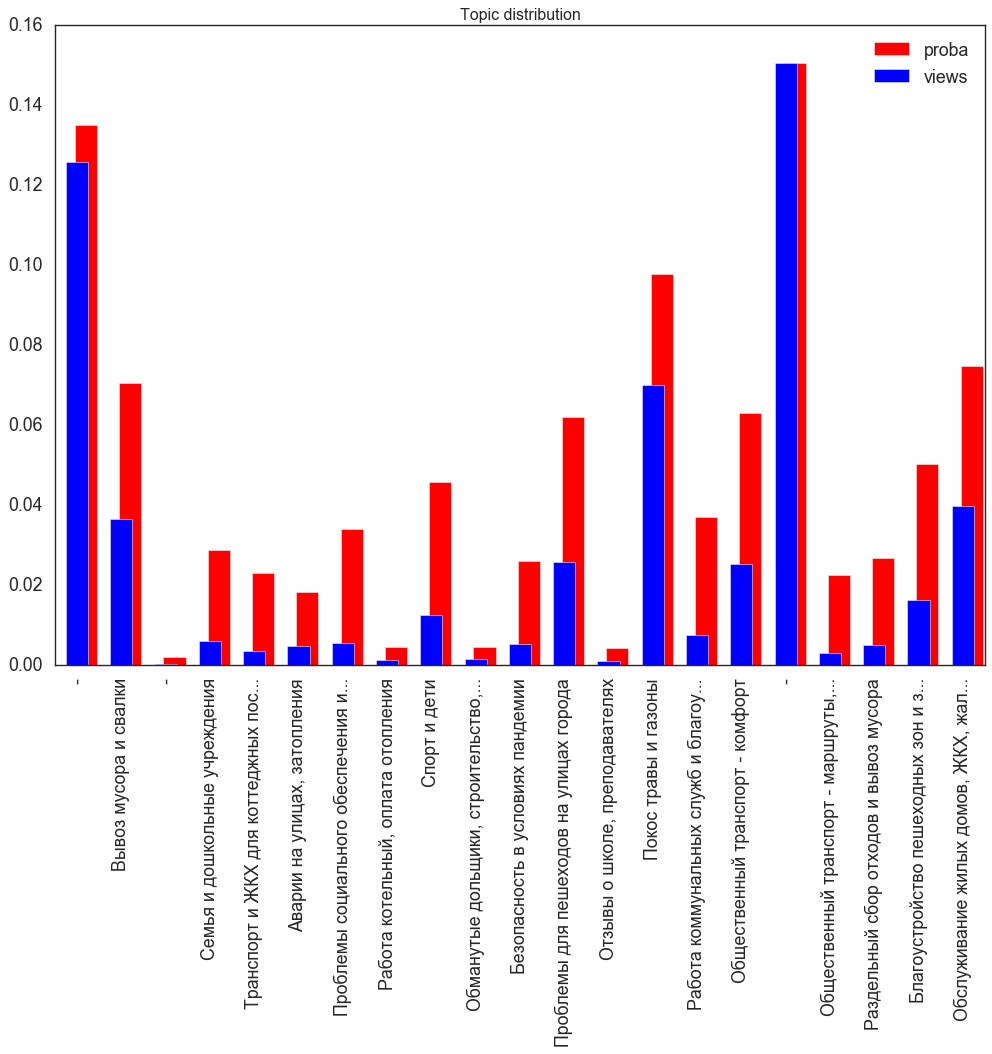

In [966]:
plot_topic_proba(proba,views,to_plot)

## - здесь proba - вероятность/частота появления темы во всех полученных данных, как среднее от вероятности по топикам. Количество просмотров нормировано на максимум вероятности, чтобы изобразить в одной шкале.
## Как видно, распределение по количеству просмотров и по частоте появления близки, и, наверное, по ним можно судить о злободневности тех или иных тем

# Найдем топ-5 документов по заданному топику:

In [826]:
def get_top_docs(data, model, corpus, topic, qty=5):
    max_proba=[]
    for i in range(0,len(corpus)):
        text_topics=model.get_document_topics(corpus[i],minimum_probability=0.07)
        for t in text_topics:
            if t[0]==topic:
                max_proba.append((i,t[1]))
                break
    max_proba = sorted(max_proba, key=lambda w: w[1], reverse=True)
    doc_ids=[a[0] for a in max_proba[0:qty]]
    docs=data.loc[doc_ids,"text"]
    return docs

In [827]:
docs=get_top_docs(myDf,lda_model,corpus, 10)

In [835]:
topic_titles[10]

'Безопасность в условиях пандемии'

# Пример: топ-5 документов по теме "Безопасность в условиях пандемии"

In [837]:
for doc in docs:
    print(doc, '\n')

Сегодня позвонила знакомой, (проживает в г.Троицк Октябрьский проспект) и с ужасом услышала вопиющую историю. Муж (Березкин Александр Сергеевич) плохо себя почувствовал еще 25 марта, обратились в поликлинику. До 16 апреля трижды были обращения к разным терапевтам, никаких толком назначений не было.Квалифицированной медпомощи НИКАКОЙ. В тесте на короновирус отказано. После трех недель домашнего лечения, 16 апреля мужа увезли в больницу в Москву в ужасном состоянии. Пневмония и подтверждение КОРОНОВИРУСА. Дома осталась жена, дочь и внучка.(Им тест никто не делал и не предлагают). Как здравомыслящие люди, естественно не выходят из дома ни за продуктами, ни за лекарствами(плохо себя чувствуют все). Пытаются дозвониться хоть куда нибудь, чтобы оказали им помощь.Дозвониться просто не реально.На горячей линии потребовали номер пробирки анализа мужа(Вообще ни в какие ворота).Вообщем люди брошены со своей бедой. Ни волонтеров, ни каких либо других, кто помогает и контролирует.!!! ни звонка от м

# Топ-5 документов по теме "Покос травы и газоны"

In [840]:
docs=get_top_docs(myDf,lda_model,corpus, 13)

In [841]:
topic_titles[13]

'Покос травы и газоны'

In [842]:
for doc in docs:
    print(doc, '\n')

Владимир Евгеньевич, здравствуйте!
Пришла весна, и опять начались бесконечные сенокосы во дворах.
В Троицке других проблем разве нет, кроме покосов травы во дворах? Предприятия остановлены, экономика в сложном положении, а нам обязательно надо траву во дворах стричь? Какой-то пир во время чумы, иначе не скажешь. Не лучше ли направить средства, затрачиваемые на выкос травы, на закупку средств защиты для медиков в больницу РАН (недавно сообщалось, что их не хватает), или ещё на что-нибудь полезное.
Москвичей загнали по домам сидеть, большинство организаций не работает, зато гастарбайтеры с бензотриммерами без проблем трудятся.  В микрорайоне В третий день с утра до вечера стоит истошный визг от триммеров, дома невозможно находиться.Эти покосы никому не нужны, уродуются лужайки во дворах. Вчера и сегодня они поганят лужайки во дворах В-6, В-8 и во дворе спортшколы, завтра будут ещё где-то. Кто там косит, ДХБ, или управляющие компании, я не знаю, и это неважно, всё равно указания на покосы

# Распределение тем по месяцам

In [975]:
def topics_on_month(df, model, corpus,topic_titles,n_topics):
    topic_on_month=pd.DataFrame(index=range(1,13), columns=[topic_titles[i] for i in range(0,n_topics)])
    for month in range(1,13):
        month_indicies=df.loc[myDf["month"]==month,:].index
        month_corpus=[corpus[i] for i in month_indicies]
        month_topics=get_topics_proba(model,month_corpus, n_topics)
        topic_on_month.loc[month,:]=month_topics
    return topic_on_month

In [976]:
topic_on_month=topics_on_month(myDf,lda_model,corpus, topic_titles, n_topics)

In [977]:
topic_on_month

- Вывоз мусора и свалки            - Семья и дошкольные учреждения  \
1   0.135054             0.0669461   0.00087542                     0.0224876   
2    0.14034             0.0615044   0.00147079                     0.0270665   
3   0.139004             0.0603492   0.00137802                     0.0346765   
4   0.143605             0.0651387  0.000782336                     0.0396501   
5   0.132391             0.0681927   0.00607212                     0.0266534   
6   0.133284             0.0772449   0.00111908                     0.0273543   
7   0.144667             0.0770486   0.00116247                     0.0267931   
8   0.128939             0.0755937   0.00162919                     0.0251748   
9   0.131643             0.0627339   0.00447354                     0.0289771   
10  0.133382             0.0786071  0.000690441                     0.0257322   
11  0.134616             0.0812006  0.000828899                     0.0293166   
12  0.124663             0.0669867   0.00126359                     0.0324047   

   Транспорт и ЖКХ для коттеджных поселков на окраинах  \
1                                           0.0194514    
2                                           0.0291133    
3                                           0.0255197    
4                                           0.0210088    
5                                           0.0221607    
6                                           0.0186249    
7                                           0.0240436    
8                                           0.0243397    
9                                           0.0244607    
10                                          0.0197301    
11                                          0.0240095    
12                                          0.0233401    

   Аварии на улицах, затопления Проблемы социального обеспечения и комфорта  \
1                     0.0122278                                   0.0305682   
2                     0.0169794                                    0.035762   
3                     0.0147795                                   0.0330223   
4                     0.0177376                                   0.0388968   
5                     0.0175898                                   0.0359653   
6                     0.0184714                                   0.0303417   
7                      0.019659                                    0.034733   
8                     0.0215388                                   0.0286355   
9                     0.0212617                                   0.0331741   
10                    0.0171727                                   0.0358389   
11                    0.0203847                                   0.0333185   
12                    0.0198862                                   0.0375575   

   Работа котельный, оплата отопления Спорт и дети  \
1                          0.00524666    0.0528811   
2                          0.00320889    0.0446247   
3                          0.00625373    0.0457101   
4                          0.00712827    0.0475961   
5                           0.0027306     0.040553   
6                          0.00199643    0.0451225   
7                          0.00554968    0.0425214   
8                          0.00285985    0.0449293   
9                          0.00551593    0.0485673   
10                         0.00437986    0.0444659   
11                         0.00474509    0.0444399   
12                         0.00476902    0.0487897   

   Обманутые дольщики, строительство, кооперативы  ...  \
1                                       0.0085708  ...   
2                                      0.00598161  ...   
3                                      0.00312385  ...   
4                                      0.00141804  ...   
5                                      0.00453302  ...   
6                                       0.0052063  ...   
7                                      0.00314897  ...   
8      

## Строим 21 гистограмму по числу тем - для каждой темы - вероятность появления в том или ином месяце (месяца - 1-12)

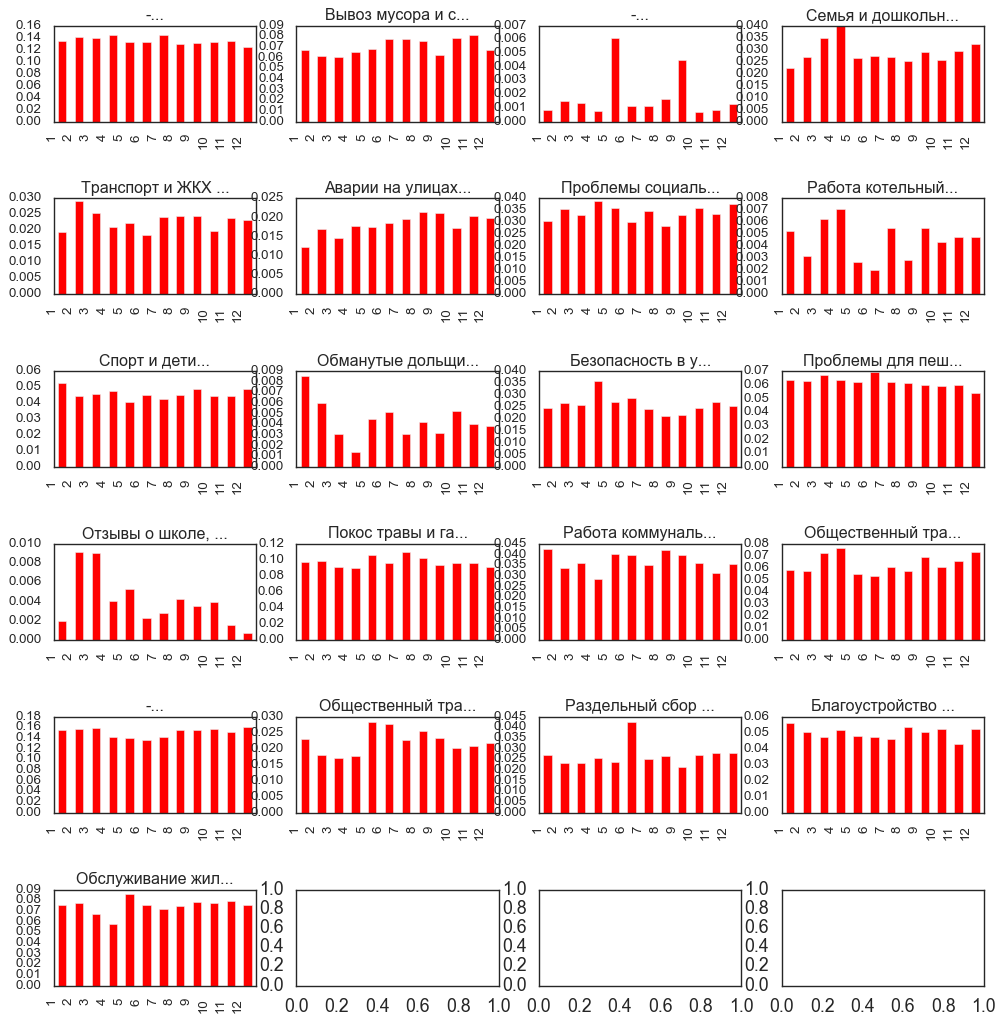

In [988]:
fig, ax=plt.subplots(figsize=(15,15), nrows=6,ncols=4)
plt.subplots_adjust(hspace = 0.8)
for i in range(1,22):
    plt.subplot(6,4,i)
    plt.xticks(rotation=60, ha="right",fontsize=12);
    plt.yticks(fontsize=12);
    topic_on_month.iloc[:,i-1].plot(kind='bar', title=topic_on_month.columns[i-1][0:16]+'...', legend=False, color='red', position=0.0)

## К сожалению, не очень показательно
## Попробуем построить распределение по месяцам количества обращений для каждой темы (т.е., таких обращений, где тема входит в первую тройку по частоте)

In [1026]:
def topics_on_month2(df, model, corpus,topic_titles,n_topics):
    topic_on_month=pd.DataFrame(index=range(1,13), columns=[topic_titles[i] for i in range(0,n_topics)])
    topic_on_month.loc[:,:]=0
    for month in range(1,13):
        month_indicies=df.loc[myDf["month"]==month,:].index
        month_corpus=[corpus[i] for i in month_indicies]
        for i in range(0,len(month_corpus)):
            text_topics=model.get_document_topics(month_corpus[i],minimum_probability=0.07)
            text_topics=sorted(text_topics, key=lambda w: w[1], reverse=True)
            text_topics=text_topics[0:3] # оставляем три наиболее вероятных темы
            for t in text_topics:
                topic_on_month.iloc[month-1,t[0]]+=1
        return topic_on_month

In [1027]:
topic_on_month2=topics_on_month2(myDf,lda_model,corpus, topic_titles, n_topics)

In [1028]:
topic_on_month2

- Вывоз мусора и свалки  - Семья и дошкольные учреждения  \
1   57                     9  0                             1   
2   56                     7  0                             3   
3   52                     8  0                             4   
4   63                    11  0                             9   
5   69                    24  1                             2   
6   53                    15  0                             2   
7   53                    18  0                             0   
8   83                    28  0                             3   
9   48                    15  0                             3   
10  68                    22  0                             2   
11  46                    16  0                             3   
12  47                    13  0                             6   

   Транспорт и ЖКХ для коттеджных поселков на окраинах  \
1                                                   0    
2                                                   4    
3                                                   5    
4                                                   3    
5                                                   2    
6                                                   1    
7                                                   2    
8                                                   2    
9                                                   1    
10                                                  0    
11                                                  1    
12                                                  2    

   Аварии на улицах, затопления Проблемы социального обеспечения и комфорта  \
1                             1                                           2   
2                             2                                           3   
3                             0                                           2   
4                             3                                           6   
5                             2                                           3   
6                             2                                           1   
7                             3                                           2   
8                             5                                           2   
9                             2                                           3   
10                            3                                           3   
11                            2                                           3   
12                            3                                           4   

   Работа котельный, оплата отопления Спорт и дети  \
1                                   0            7   
2                                   1            5   
3                                   2            9   
4                                   2            7   
5                                   0            6   
6                                   0            4   
7                                   0            5   
8                                   0            7   
9                                   1            6   
10                                  0            7   
11                                  0            4   
12                                  1            4   

   Обманутые дольщики, строительство, кооперативы  ...  \
1                                               2  ...   
2                                               0  ...   
3                                               0  ...   
4                                               0  ...   
5                                               1  ...   
6                                               1  ...   
7                                               1  ...   
8                                               1  ...   
9                                               1  ...   
10                                              0  ...   
11                                 

## Распределения количества обращений по месяцам для каждой темы

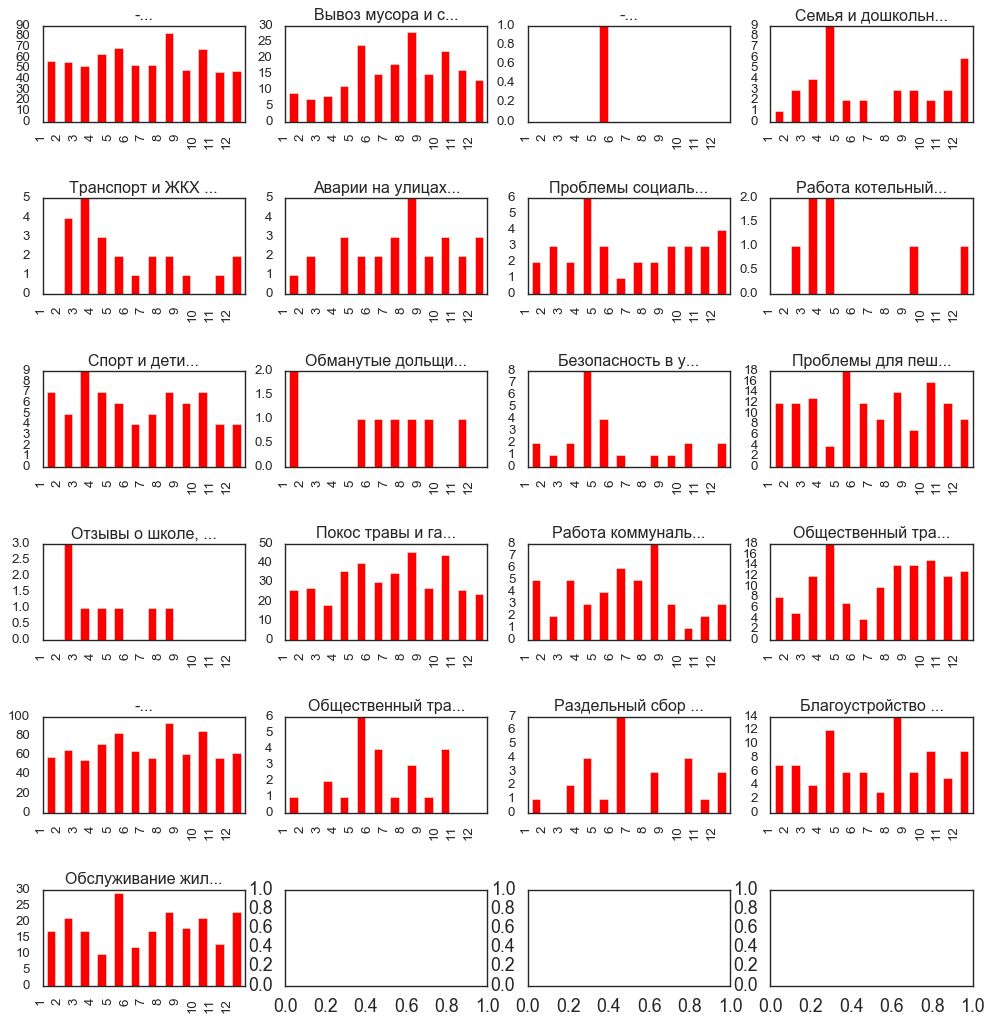

In [1029]:
fig, ax=plt.subplots(figsize=(15,15), nrows=6,ncols=4)
plt.subplots_adjust(hspace = 0.8)
for i in range(1,22):
    plt.subplot(6,4,i)
    plt.xticks(rotation=60, ha="right",fontsize=12);
    plt.yticks(fontsize=12);
    topic_on_month2.iloc[:,i-1].plot(kind='bar', title=topic_on_month2.columns[i-1][0:16]+'...', legend=False, color='red', position=0.0)

### Теперь, по крайней мере, видно, что вопросы стрижки газонов поднимаются в большей степени с мая по сентябрь, а к котельной в это время, наоборот, претензий нет.

# Темы, поднимаемые, наиболее активными авторами

In [1048]:
myDf.author.value_counts()[0:9]

н.н.                            36
wolf838                         34
olezek1                         27
Volfovich                       19
Дудочкин Владимир Евгеньевич    17
ПРЕДСЕДАТЕЛЬ31                  14
Zilber                          13
ichertok                        13
sam199541                       12
Name: author, dtype: int64

In [1062]:
def auth_topics(auth, corpus=corpus, lda_model=lda_model, n_tpoics=n_topics, topic_titles=topic_titles):
    NN_indicies=myDf.loc[myDf["author"]==auth,:].index
    NN_corpus=[corpus[i] for i in NN_indicies]
    NN_proba=get_topics_proba(lda_model,NN_corpus, n_topics)
    NN_scores=[0]*n_topics
    for i in range(0,len(NN_proba)):
            text_topics=lda_model.get_document_topics(NN_corpus[i],minimum_probability=0.07)
            text_topics=sorted(text_topics, key=lambda w: w[1], reverse=True)
            text_topics=text_topics[0:3] # оставляем три наиболее вероятных темы
            for t in text_topics:
                NN_scores[t[0]]+=1
    NN_df=get_topic_df(topic_titles)
    NN_df["score"]=NN_scores
    plt.figure(figsize=(12,8))
    NN_df["score"].plot(kind='bar', title="Topic distribution", legend=True, color='red', position=0.1)

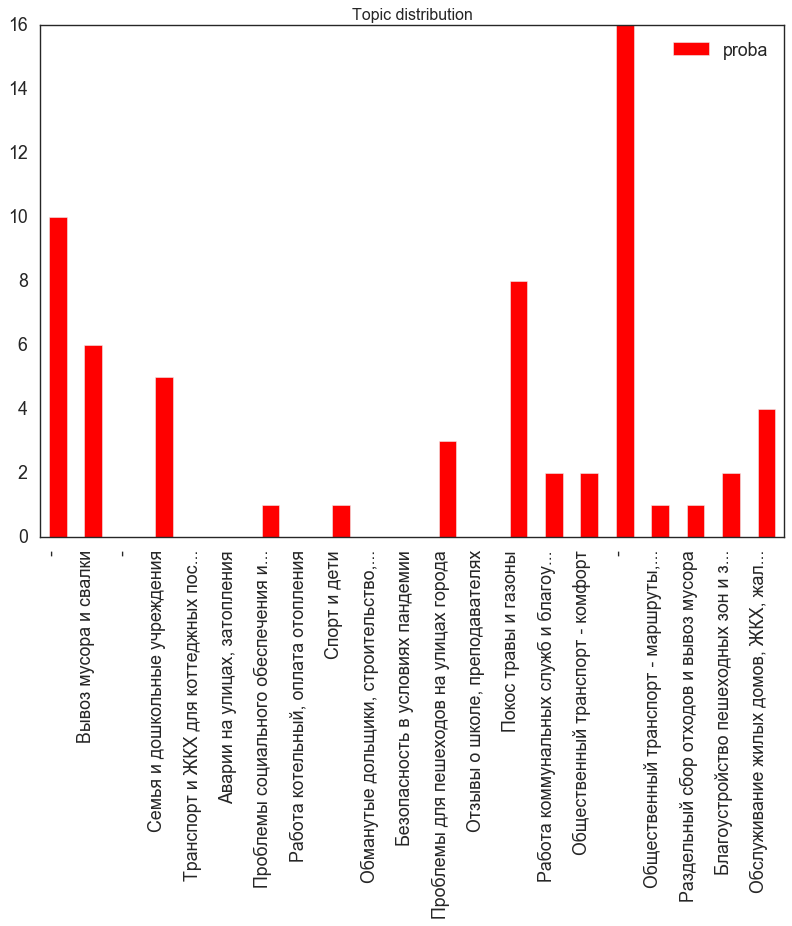

In [1063]:
auth_topics("н.н.")

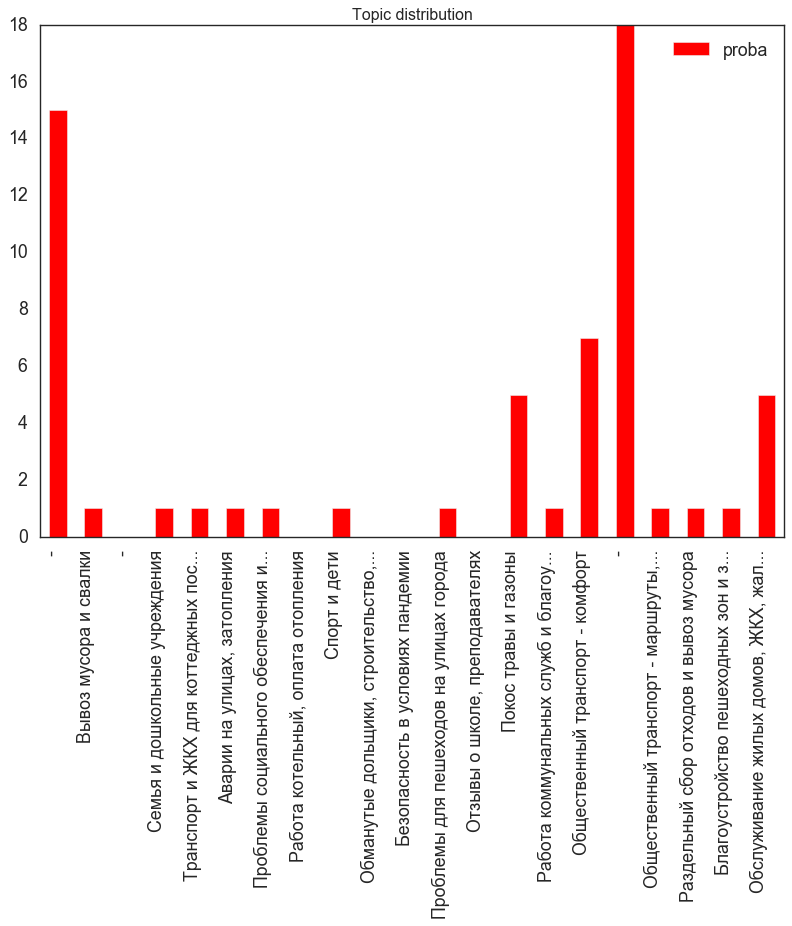

In [1064]:
auth_topics("wolf838")